# Roberto Di Via 4486648 - DSIP PROJECT
## Study the 2-D Haar wavelets and its application to image compression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, io, color
from matplotlib import cm
import pywt
%matplotlib inline

# Introduction
My project focus on the Haar wavelet transform, its usage in image compression, as well
as the performance on different types of images.
First i describe what is image compression, then i try the Fourier transform and finally the 2-D Haar Wavelets.


### Image compression
Image compression is the name with which we refer to a class of compression algorithms applied to digital images. 
As the specificity of the name implies, they differ slightly from generic compression algorithms since they exploit human visual perception and other image unique qualities.

The main benefits of image compression are the same as every other type of compression method: <b>reduction of both storage used and data transmitted</b>.

There are however other features that may be useful, depending on the use of the images compressed, such as scalability, region of interest coding, flexibility, error resilience, etc.


### Lossy and Lossless compression
As with all data compression methods, image compression algorithms can be divided in two main groups:

• <b>Lossy methods:</b> which lose information, meaning it is not possible to reconstruct the original data

• <b>Lossless methods:</b> which preserve information, and are able to retrieve the uncompressed data


## Compress Ratio - MSE 
I decide to use the Mean squared error (MSE) to evaluate the quality of the between the compressed image with reference to the original one

In [2]:
def MSE(compressed, original):
    mse = np.mean((original.flatten() - compressed.flatten())**2)
    return round(mse, 10)

## FFT compression
To understand how wavelets compression works we analyze first how it is possible to compress an image with the Fourier Transform.

The Fourier Transform allows us to represent a signal in its frequency domain. Since we are discussing images, we are working in a two-dimensional space, so we need a 2D FFT which is achieved by applying first the FFT to every row, and then to every column (or vice versa).

Analyzing the spectrogram of an image we can observe that most of its coefficient are zero or small values in magnitude. To save an image we can just save the Fourier coefficients that are not zero, and their locations because in this way we store a lot less information compared to saving every pixel value.

Since a small coefficient will not have a significant impact on the image reconstruction, we can just remove a certain percentage of the smallest coefficients by thresholding the transform to reduce the size of the 
image furthermore. 

The details we remove will be lost and the image quality will decrease, so this is a lossy 
operation.


Shape: (512, 512)


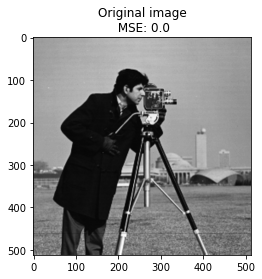

In [3]:
img = pywt.data.camera() # already gray scale

plt.title("Original image"+"\n MSE: {}".format(MSE(img, img)))
plt.imshow(img, cmap='gray') 
print("Shape:", img.shape)

In [4]:
def fft_compress(img, compression_value):
    img_ftt = np.fft.fft2(img)
    ftt_sorted = np.sort(img_ftt, axis=None) # Array of coefficient sorted by magnitude increasing
    
    #Thresholding
    #First i compute how much of the array consider, for example 50%, 
    #i take the index that will be the starting value to threshold    
    thresh = ftt_sorted[ int(np.floor((1-compression_value)* len(ftt_sorted))) ]
    
    #Filtered spectogram
    # Copy of array where if value>thresh i keep it otherwise i put 0
    filtered_array = np.where(abs(img_ftt) > thresh, img_ftt, 0) 
    
    #Compressed image
    img_compressed = np.fft.ifft2(filtered_array).real #Inverse transform with zero out all small coefficents

    return img_compressed

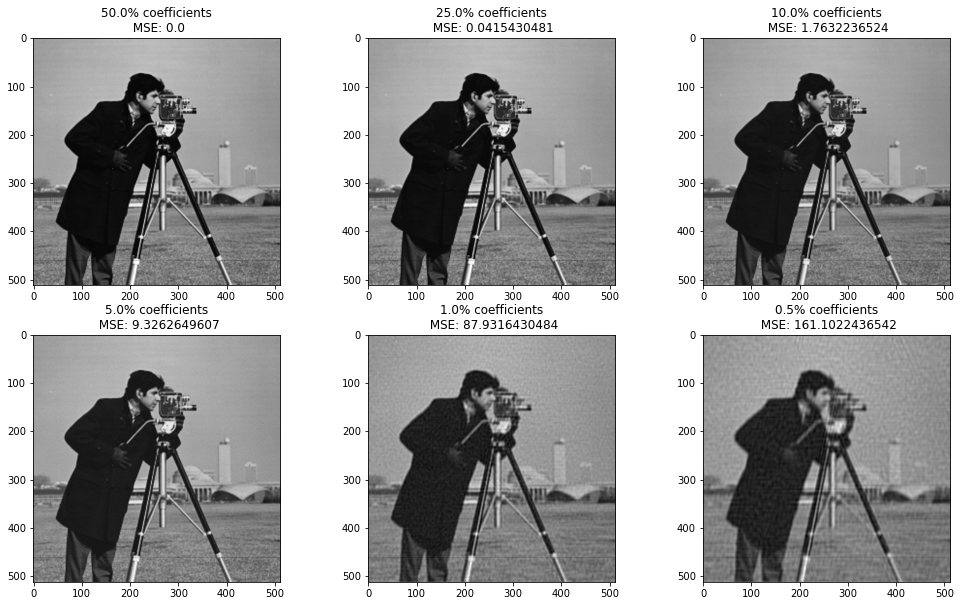

In [5]:
compression = [0.5, 0.25, 0.10, 0.05, 0.01, 0.005] #Percentage of coefficient we retain for each experiment
mse_list = []

fig, axs = plt.subplots(2,3, figsize=(17, 10))
axs = axs.ravel()
    
for i in range(len(compression)):
    img_compressed = fft_compress(img, compression[i])
    
    mse = MSE(img, img_compressed)
    mse_list.append(mse)
    
    #Plot Reconstruction
    axs[i].imshow(img_compressed, cmap='gray') 
    axs[i].set_title(str(compression[i]*100)+"% coefficients"+"\n MSE: {}".format(mse))

We can see that even an aggressive compression with only 5% of the coefficient is almost the same because most of the coefficients will be really small in magnitude and will have minor impact on the image reconstruction

Text(0, 0.5, '% Error')

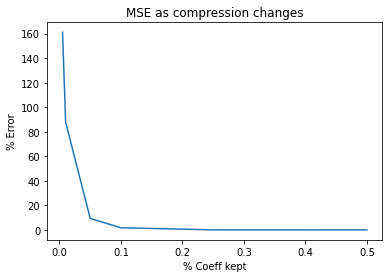

In [6]:
fig, ax = plt.subplots()
ax.set_title("MSE as compression changes")
ax.plot(compression, mse_list)
ax.set_xlabel("% Coeff kept")
ax.set_ylabel("% Error")

## Haar Wavelet compression

The concepts for the wavelet compression are the same as the FFT compression.
The wavelet transforms of a signal allow us to represent the signal in a lower frequency, while saving also 
the information needed to reconstruct the original image (detailed coefficients). 

The Haar transform is one of the simplest discrete wavelet transforms. It is based on the idea of decomposing a signal into two components: one is the average (approximation), and the other is the difference (detail). 

The Haar wavelet transform only works with powers of 2. This is due to the fact that averaging and differencing are applied to two values by two. If the image is not of size $2^p × 2^q$ with p, and q ∈ N, an error message is displayed


It can be sum up with the following formula:
$$ (a,b) = \left(\frac{a+b}{w}, \frac{a-b}{w}\right)$$

Where:
- w = the scale or weight factor. 
- output a = average
- output b = difference


#### Example
In order to show how the Haar wavelet transform works, we will take the following onedimensional array r:

$$ r = (156, 159, 158, 155, 158, 156, 159, 158)$$
Group the columns in pairs: $$[156, 159], [158, 155], [158, 156], [159, 158]$$

Then replace the 4 first columns of r with the average and the last 4 with the difference 
$$ r'=(\underbrace{157.5, 156.5, 157, 158.5}_{average}, \underbrace{−1.5, 1.5, 1, 0.5}_{difference}) $$

Then we repeat the procedure on the first half of the array, so:
Group the first four columns of r' in pairs: $$[157.5, 156.5], [157, 158.5]$$

Then replace the 2 first columns of r' with the average and the following 2 with the difference
$$ r'' = (\underbrace{157, 157.75}_{average}, \underbrace{0.5, −0.75}_{difference}, −1.5, 1.5, 1, 0.5) $$

We can notice that the high intensity information gets pushed to the left, while the rest of the list would describe changes in the previous data.

The beauty of what we have done so far lies in the fact that it is completely reversible. We are able to reconstruct the original array. We call this type of compression <b>lossless</b>. 

For greater reduction, we can implement <b>lossy compression by using a threshold</b> value. This new array will, consequently, have more 0 entries and so will be even more compressed. We lose some precision in order to gain in compression.



### Haar wavelet for images
Luckily, images can be represented in the form of matrices. In this project, i'll work principally with two types of images: grayscale and colored.

If we process a <b>grayscale image</b>, each entry of the matrix determines the intensity of the pixel it represents. This intensity is expressed by an integer ranging from 0 to 255; with 0 indicating black which is the color with minimal intensity, and 255 indicating white which is the color with maximal intensity.

As for <b>color images</b>, assuming that we are following the RGB color system, we can represent them using three matrices; one for each: red, green, and blue (RGB). The entries of each one of the three matrices are integers between 0 and 255 again, determining the intensity of the pixel with respect to the color defined by the matrix.


Since we are working with images, we need the <b>2-dimensional DWT</b> (Discrete Wavelet Transform) obtained by applying the DWT on the row first, and then on the columns (like the 2-D FFT). 

After this operation, the resulting image will be divided in <b>4 sub-bands</b>. 

<img src="images\haar_compression.ppm"  width=500 height=300>

In the top left it is stored the lower frequency image obtained after a <b>low pass filter</b>.

The rest are the higher frequencies information detail coefficient obtained after a <b>high pass filter</b>. 

These detailed coefficients are divided in horizontal detail (top right), vertical details (bottom left), diagonal details (bottom right).


### Haar wavelet with Pywt

Wavelets compression it's used in many practical compressors like JPEG2000, DjVu or ECW. In this case i implemented the Haar wavelet with the <a href="https://pywavelets.readthedocs.io/en/latest/ref/2d-dwt-and-idwt.html#d-multilevel-decomposition-using-wavedec2">PyWt library</a>.


In [7]:
def haar_wt_compress(img, compression_value, wt, n_lev):
    
    #Wavelet transform
    coeffs = pywt.wavedec2(img,wavelet=w,level=n) # the result is a list of coefficient for each level
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs) #Transform the list into a array for simpler computations

    #Coefficients sorted by magnitude
    coeff_sort = np.sort(np.abs(coeff_arr), axis = None) 

    #Thresholding
    thresh = coeff_sort[int(np.floor((1-compression_value)*len(coeff_sort)))]
    
    # Filter the wavelet transform 
    Cfilt = np.where(abs(coeff_arr) > thresh, coeff_arr, 0) 
    
    #Reconstruct coefficient list
    coeffs_filt = pywt.array_to_coeffs(Cfilt,coeff_slices,output_format='wavedec2') 
    
    #Reconstruct image
    img_compressed = pywt.waverec2(coeffs_filt,wavelet=w) 

    return img_compressed, coeff_arr

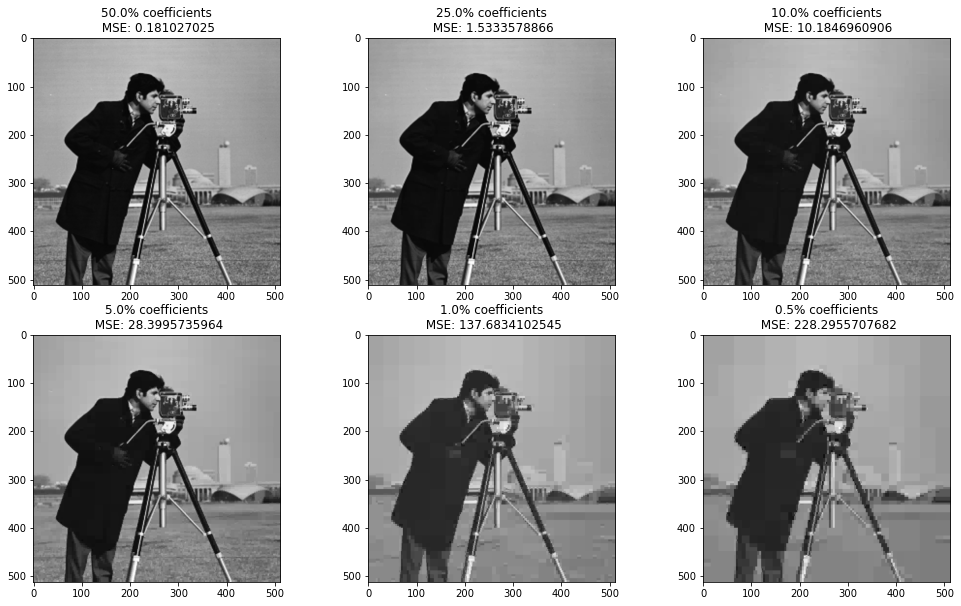

In [8]:
n=8 #Levels of the wavelet transform 
w="haar" #Type of wavelet

compression = [0.5, 0.25, 0.10, 0.05, 0.01, 0.005] #Percentage of coefficient we retain for each experiment
mse_list = []

fig, axs = plt.subplots(2,3, figsize=(17, 10))
axs = axs.ravel()
    
for i in range(len(compression)):
    img_compressed, coeff_arr = haar_wt_compress(img, compression[i], w, n)
    
    mse = MSE(img, img_compressed)
    mse_list.append(mse)
    
    #Plot Reconstruction
    axs[i].imshow(img_compressed, cmap='gray') 
    axs[i].set_title(str(compression[i]*100)+"% coefficients"+"\n MSE: {}".format(mse))

(-200.0, 200.0)

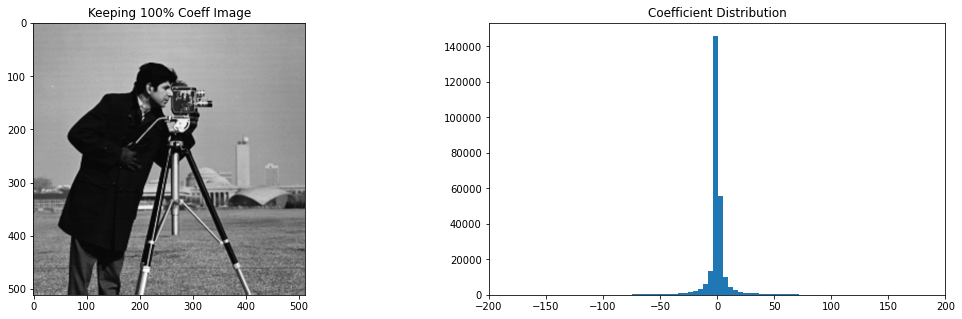

In [9]:
img_compressed, coeff_arr = haar_wt_compress(img, 1, w, n)

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.title("Keeping 100% Coeff Image")
plt.imshow(img, cmap='gray') 

plt.subplot(1,2,2)
plt.title("Coefficient Distribution")
plt.hist(coeff_arr.ravel(), 10000);
plt.xlim([-200, 200])

Observe that coefficients are concentrated around zero. That means that many coefficients are close to zero, so we can throw away to reduce the size of the image.

Alternatively, we can monitor how the error changes as we keep a different percentage of coefficients.

Text(0, 0.5, '% Error')

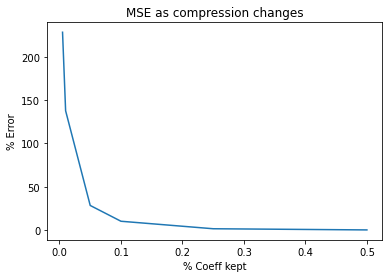

In [10]:
fig, ax = plt.subplots()
ax.set_title("MSE as compression changes")
ax.plot(compression, mse_list)
ax.set_xlabel("% Coeff kept")
ax.set_ylabel("% Error")

### Procedure for Haar Wavelet Transform
To calculate the Haar transform of an array of n samples: 
<ol>
    <li>Find the average of each pair of samples. (n/2 averages)</li>
    <li>Find the difference between each average and the samples it was calculated from. (n/2 differences)</li>
    <li>Fill the first half of the array with averages.</li>
    <li>Fill the second half of the array with differences.</li>
    <li>Repeat the process on the first half of the array. (The array length should be a power of two)</li> 
</ol>


In [11]:
scale = 2 # or we can use the normalized square(2)

In [12]:
# 1D
def hwt(wt, n, copy=True):
  if copy: wt = np.copy(wt)

  sums = (wt[:n:2] + wt[1:n:2]) / scale
  difs = (wt[:n:2] - wt[1:n:2]) / scale
  wt[:n] = np.concatenate((sums, difs))

  return wt

def ihwt(wt, n, copy=True):
  if copy: wt = np.copy(wt)

  sums = wt[:n // 2] * scale
  difs = wt[n // 2:n] * scale
  wt[:n:2] = (sums + difs) / 2
  wt[1:n:2] = (sums - difs) / 2

  return wt

In [13]:
# 2D
def hwt2(wt, iterations, copy=True):
  if copy: wt = np.copy(wt)

  h, w = wt.shape
  for i in range(iterations):
    wt = np.apply_along_axis(hwt, 0, wt, h, copy=False)
    wt = np.apply_along_axis(hwt, 1, wt, w, copy=False)
    h //= 2
    w //= 2
  return wt

def ihwt2(wt, iterations, copy=True):
  if copy: wt = np.copy(wt)

  h, w = wt.shape
  h //= 2 ** (iterations - 1)
  w //= 2 ** (iterations - 1)
  for i in range(iterations):
    wt = np.apply_along_axis(ihwt, 0, wt, h, copy=False)
    wt = np.apply_along_axis(ihwt, 1, wt, w, copy=False)
    h *= 2
    w *= 2
  return wt

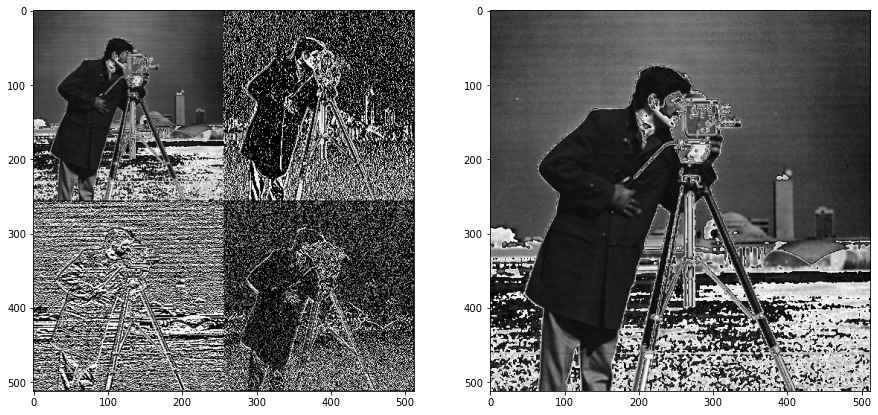

In [14]:
iterations = 1

hwt_img = hwt2(img, iterations)
img_compressed = ihwt2(hwt_img, iterations)

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.imshow(hwt_img, cmap=cm.gray)

plt.subplot(1,2,2)
plt.imshow(img_compressed, cmap=cm.gray)

By applying the transform we can see that the top left still maintains most of the high intensity values, being the average of each 2 × 2 blocks of the original image, while the other three carry information about the horizontal (top right-hand corner), vertical (bottom left-hand corner) and diagonal (bottom right-hand corner) differences.

We can now reiterate the process multiple times to push the energy toward the top left-hand corner, as we can see in the following images, representing the result we obtain by applying the 2D HWT two times:

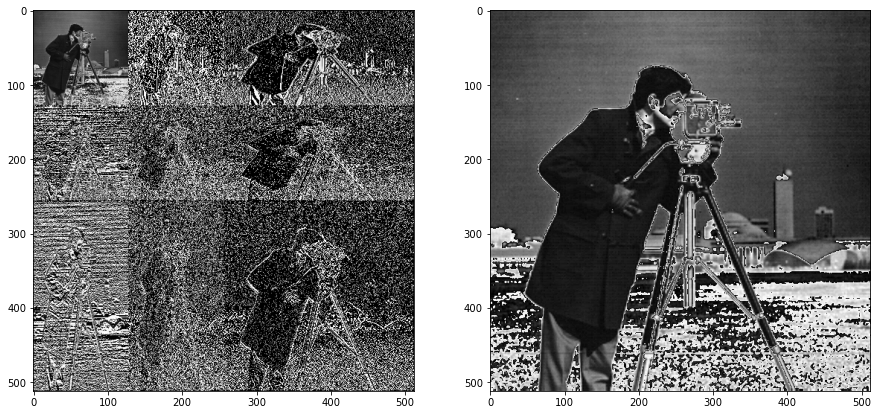

In [15]:
iterations = 2

hwt_img = hwt2(img, iterations)
img_compressed = ihwt2(hwt_img, iterations)

plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.imshow(hwt_img, cmap=cm.gray)

plt.subplot(1,2,2)
plt.imshow(img_compressed, cmap=cm.gray)

## RGB Image Compression

To handle RGB images we need to define the function to convert them into a different color (YCbCr) space to manipulate the different channels indipendentely.

In [16]:
def rgb2ycbcr(im):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = im.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

def ycbcr2rgb(im):
    xform = np.array([[1, 0, 1.402], [1, -0.34414, -.71414], [1, 1.772, 0]])
    rgb = im.astype(np.float)
    rgb[:,:,[1,2]] -= 128
    rgb = rgb.dot(xform.T)
    np.putmask(rgb, rgb > 255, 255)
    np.putmask(rgb, rgb < 0, 0)
    return np.uint8(rgb)

I choosed an image where the Fourier Transform can't find any periodicity, in order to see if the haar wavelet perform better than it.

(512, 512, 3)


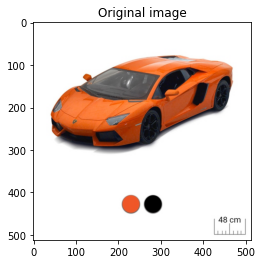

In [34]:
#imgRGB = data.astronaut()
imgRGB = io.imread("images/auto.jpg")
plt.title("Original image")
plt.imshow(imgRGB) 
print(imgRGB.shape)

### Using FFT Compression

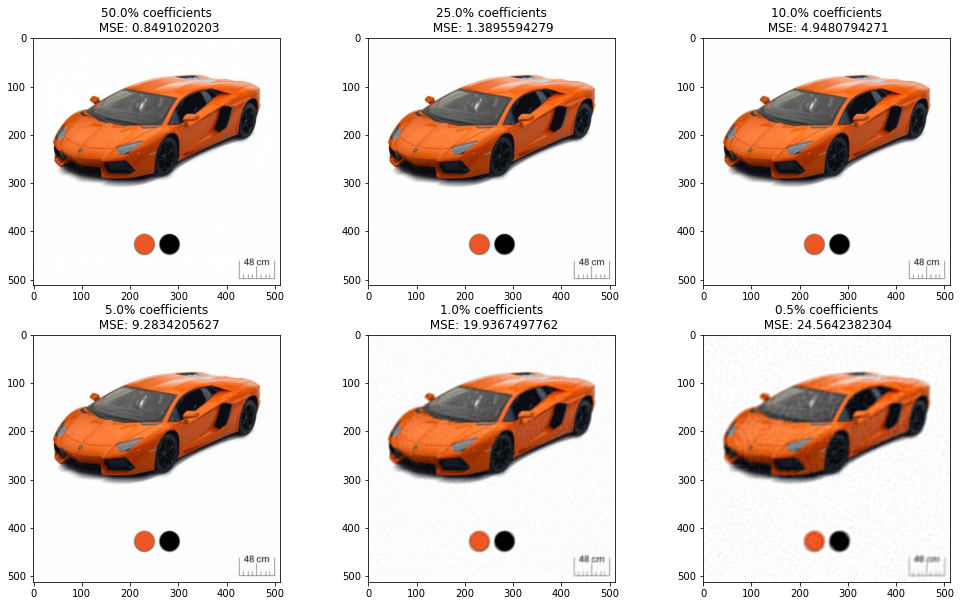

In [35]:
compression = [0.5, 0.25, 0.10, 0.05, 0.01, 0.005] #Percentage of coefficient we retain for each experiment
mse_list = []

imgYCbCR = rgb2ycbcr(imgRGB) # convert to YCbCr
    
Y = imgYCbCR[:, :, 0]
Cb = imgYCbCR[:, :, 1]
Cr = imgYCbCR[:, :, 2]

fig, axs = plt.subplots(2,3, figsize=(17, 10))
axs = axs.ravel()
    
for i in range(len(compression)):
    
    # process Y
    Y_compressed = fft_compress(Y, compression[i])
    
    # process Cb
    Cb_compressed = fft_compress(Cb, compression[i])
   
    # process Cr
    Cr_compressed = fft_compress(Cr, compression[i])
    
    # Reconstruct RGB image compressed
    img_compressed = ycbcr2rgb(np.dstack((Y_compressed, Cb_compressed, Cr_compressed)))

    mse = MSE(imgRGB, img_compressed)
    mse_list.append(mse)
    
    #Plot 
    axs[i].imshow(img_compressed) 
    axs[i].set_title(str(compression[i]*100)+"% coefficients"+"\n MSE: {}".format(mse))

Text(0, 0.5, '% Error')

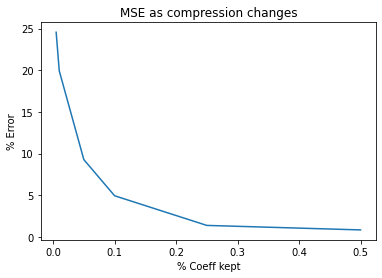

In [36]:
fig, ax = plt.subplots()
ax.set_title("MSE as compression changes")
ax.plot(compression, mse_list)
ax.set_xlabel("% Coeff kept")
ax.set_ylabel("% Error")

### Using Haar Wavelet Compression

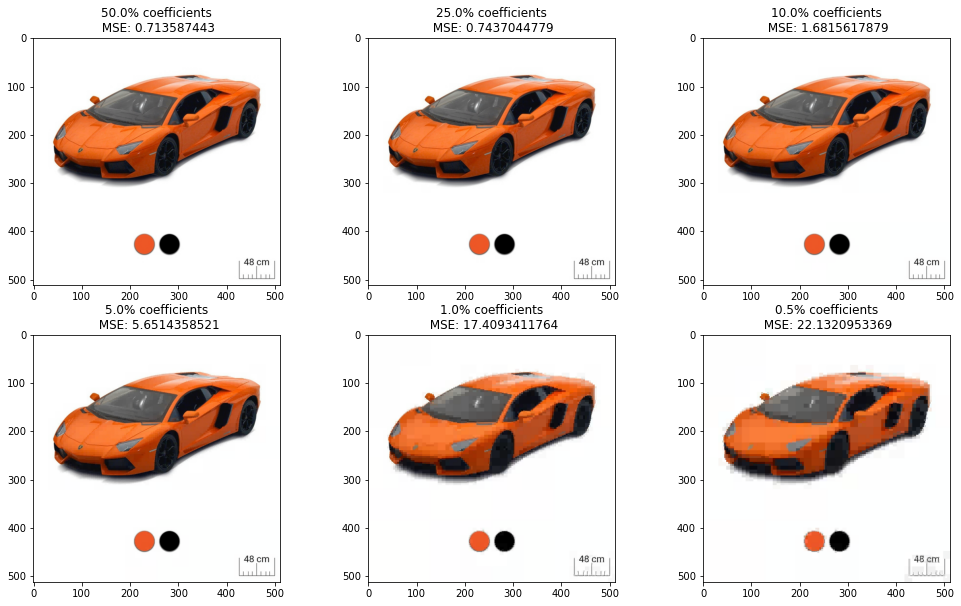

In [37]:
n=8 #Levels of the wavelet transform 
w="haar" #Type of wavelet

compression = [0.5, 0.25, 0.10, 0.05, 0.01, 0.005] #Percentage of coefficient we retain for each experiment
mse_list = []

imgYCbCR = rgb2ycbcr(imgRGB) # convert to YCbCr
    
Y = imgYCbCR[:, :, 0]
Cb = imgYCbCR[:, :, 1]
Cr = imgYCbCR[:, :, 2]

fig, axs = plt.subplots(2,3, figsize=(17, 10))
axs = axs.ravel()
    
for i in range(len(compression)):
    
    # process Y
    Y_compressed, y_coeff_arr = haar_wt_compress(Y, compression[i], w, n)
    
    # process Cb
    Cb_compressed, cb_coeff_arr = haar_wt_compress(Cb, compression[i], w, n)
   
    # process Cr
    Cr_compressed, cr_coeff_arr = haar_wt_compress(Cr, compression[i], w, n)
    
    # Reconstruct RGB image compressed
    img_compressed = ycbcr2rgb(np.dstack((Y_compressed, Cb_compressed, Cr_compressed)))
    rgb_coeff_arr =  ycbcr2rgb(np.dstack((y_coeff_arr, cb_coeff_arr, cr_coeff_arr)))
    
    mse = MSE(imgRGB, img_compressed)
    mse_list.append(mse)
    
    #Plot 
    axs[i].imshow(img_compressed) 
    axs[i].set_title(str(compression[i]*100)+"% coefficients"+"\n MSE: {}".format(mse))

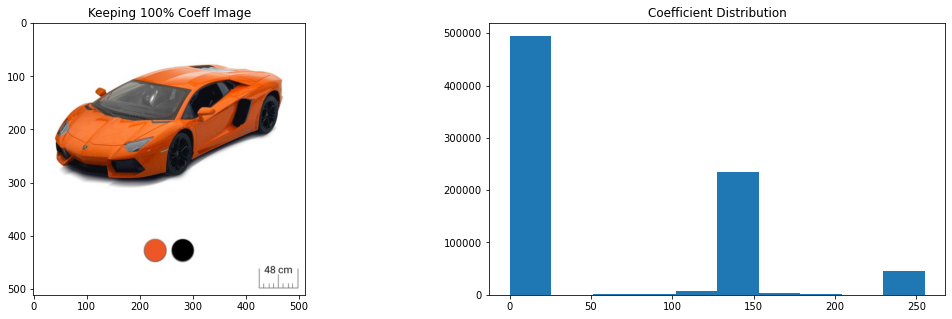

In [38]:
n=2
# process Y
Y_compressed, y_coeff_arr = haar_wt_compress(Y, 1, w, n)

# process Cb
Cb_compressed, cb_coeff_arr = haar_wt_compress(Cb, 1, w, n)

# process Cr
Cr_compressed, cr_coeff_arr = haar_wt_compress(Cr, 1, w, n)

# Reconstruct RGB image compressed
img_compressed = ycbcr2rgb(np.dstack((Y_compressed, Cb_compressed, Cr_compressed)))
rgb_coeff_arr =  ycbcr2rgb(np.dstack((y_coeff_arr, cb_coeff_arr, cr_coeff_arr)))

plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
plt.title("Keeping 100% Coeff Image")
plt.imshow(img_compressed, cmap='gray') 

plt.subplot(1,2,2)
plt.title("Coefficient Distribution")
plt.hist(rgb_coeff_arr.ravel(), 10);


Again, we can see that, even not applying any threshold (so we take the 1*100 of the vawelet), the coefficients are concentrated around zero

Text(0, 0.5, '% Error')

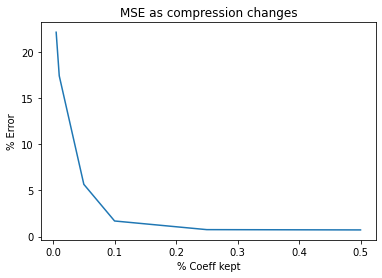

In [39]:
fig, ax = plt.subplots()
ax.set_title("MSE as compression changes")
ax.plot(compression, mse_list)
ax.set_xlabel("% Coeff kept")
ax.set_ylabel("% Error")

### The advantages of Haar Wavelet transform as follows:
<ol>
    <li>Best performance in terms of computation time.</li>
    <li>Computation speed is high.</li>
    <li>Simplicity</li>
    <li>HWT is efficient compression method</li>
    <li>It is memory efficient, since it can be calculated inplace without a temporary array</li>
</ol>

## Conclusion
At this point, we can say that building the image compressor based on the Haar wavelet transform is one of the best alternative as it is the one that yields the most visually-pleasing, and best-looking results with few efforts in terms of computation time and complexity.

## Sources:

- <a href="https://www.aui.ma/sse-capstone-repository/pdf/spring2016/Image%20Compression%20Using%20Discrete%20Wavelet%20Transforms.pdf"> Link 1 </a>
- <a href="https://www.ijarcce.com/upload/2013/august/43-h-shabanam-image%20compression%20using%20haar%20wavelet.pdf"> Link 2 </a>
- <a href="https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.511.4062&rep=rep1&type=pdf"> Link 3 </a>